In [1]:
pip install einops

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 491.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ax-platform

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.4/387.4 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 28.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import torch
import torchvision
import pandas as pd
from skimage import io, transform
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms, utils

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
train_tf = transforms.Compose([
    transforms.RandomRotation(degrees=0.66),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_data = CIFAR10(download=True, root="./data", transform=train_tf)
test_data = CIFAR10(root="./data", train=False, transform=test_tf)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
train_class_item = dict()
for item in train_data:
    label = train_data.classes[item[1]]
    if label not in train_class_item:
        train_class_item[label] = 1
    else:
        train_class_item[label] += 1
train_class_item

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [7]:
test_class_item = dict()
for item in test_data:
    label = test_data.classes[item[1]]
    if label not in test_class_item:
        test_class_item[label] = 1
    else:
        test_class_item[label] += 1
test_class_item

{'cat': 1000,
 'ship': 1000,
 'airplane': 1000,
 'frog': 1000,
 'automobile': 1000,
 'truck': 1000,
 'dog': 1000,
 'horse': 1000,
 'deer': 1000,
 'bird': 1000}

In [8]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=False)

torch.Size([16, 3, 32, 32])


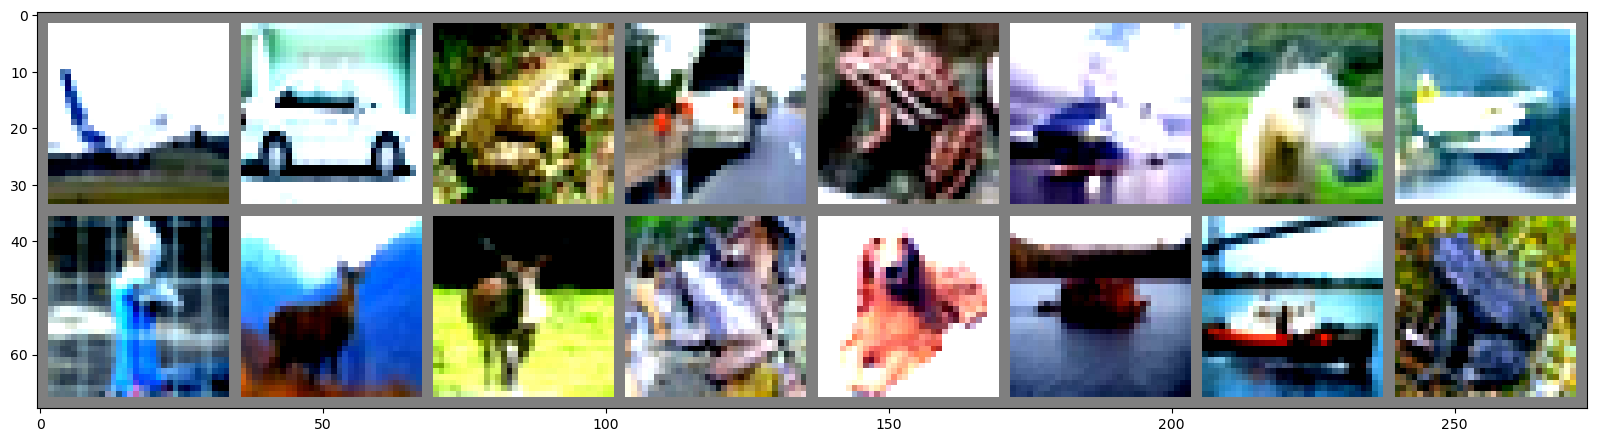

In [9]:
show_sample = DataLoader(train_data, 16, shuffle=True)

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(show_sample)
images, labels = dataiter.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [11]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)
    
train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

# Functions to visualize predictions

In [12]:
def plot_training_metrics(history, model, test_data, y_actual, y_pred, classes, model_name='model'):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_actual, y_pred, pos_label=9)
    AUC       = metrics.auc(fpr, tpr)*100
    Acc       = accuracy_score(y_actual, y_pred)*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))

    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    loss_values     = [x.get("train_loss") for x in history]
    val_loss_values = [x["val_loss"] for x in history]
    val_acc_values  = [x["val_acc"] for x in history]    
   

    # get the min loss and max accuracy for plotting
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(loss_values, 'bo', label = 'Training loss')
    plt.plot(val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()

    # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(val_acc_values, 'cornflowerblue', label = 'Validation Accuracy')
    plt.title('Validation Accuracy by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))
    
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat((all_preds, preds) ,dim=0)

    return all_preds

# CNN Model

In [13]:
class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()
        self.mlp = nn.Sequential()
        self.mlp.add_module("conv2d1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding='same'))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("conv2d2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("maxpool2d", nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.mlp.add_module("conv2d3", nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same'))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("maxpool2d", nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.mlp.add_module("conv2d4", nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding='same'))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("conv2d5", nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding='same'))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("maxpool2d", nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.mlp.add_module("flatten", nn.Flatten())
        self.mlp.add_module("linear1", nn.Linear(8192, 1024))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("linear2", nn.Linear(1024, 128))
        self.mlp.add_module("relu", nn.ReLU())
        self.mlp.add_module("linear3", nn.Linear(128, output_dim))
    
    def forward(self, x):
        out = self.mlp(x)
        return out
    
    def train_loss(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def val_loss(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss":loss.detach(), "val_acc":acc}
    
    def val_epoch_end(self, outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_acc = [acc["val_acc"] for acc in outputs]
        acc = torch.stack(batch_acc).mean()
        return {"val_loss":loss.item(), "val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Vision Transformer

In [14]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm =  nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)
        self.heads = heads
        self.scale = dim_head**-0.5
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim*3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
        
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
    
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be wither cls (cls token) or mean (mean pooling)'
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n+1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)

    def train_loss(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def val_loss(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss":loss.detach(), "val_acc":acc}
    
    def val_epoch_end(self, outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_acc = [acc["val_acc"] for acc in outputs]
        acc = torch.stack(batch_acc).mean()
        return {"val_loss":loss.item(), "val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Fit and Evaluation
Note: Since the CIFAR10 dataset has provided train/test split, I did not implement cross validation here.

In [15]:
@torch.no_grad()
def evaluate(model, test_dl):
    model.eval()
    outputs = [model.val_loss(batch) for batch in test_dl]
    return model.val_epoch_end(outputs)

In [16]:
def fit(epochs, model, model_name, train_dl, test_dl, optimizer, scheduler, lr, weight_decay, gamma, step_size):
    torch.cuda.empty_cache()
    history = []
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = scheduler(optimizer,step_size=step_size, gamma=gamma)
    print(model_name, 'fit in...')
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        scheduler.step()
        for batch in train_dl:
            loss = model.train_loss(batch)
            train_loss.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        result = evaluate(model, test_dl)
        lrs.append(scheduler.get_last_lr()[0])
        result['train_loss'] = torch.stack(train_loss).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Hyperparameters

In [17]:
epochs = 20
lr = 3e-4
weight_decay = 1e-5
gamma = 0.5
step_size = 10
optimizer = torch.optim.Adam
scheduler = torch.optim.lr_scheduler.StepLR
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

In [18]:
model_CNN = CNN(num_classes)
model_CNN = model_CNN.to(device)
model_ViT = ViT(dim=128, image_size=32, patch_size=2, depth=6, heads=16, mlp_dim=256, num_classes=num_classes, channels=3, dropout=0.1, emb_dropout=0.1)
model_ViT = model_ViT.to(device)
criterion = nn.CrossEntropyLoss()
total_step = len(train_dl)

In [19]:
%%time
cnn_history = fit(epochs, model_CNN, 'CNN', train_dl, test_dl, optimizer, scheduler, lr, weight_decay, gamma, step_size)

CNN fit in...
Epoch [0], last_lr: 0.00030, train_loss: 1.4826232194900513, val_loss: 1.2708, val_acc: 0.5467
Epoch [1], last_lr: 0.00030, train_loss: 1.1740987300872803, val_loss: 1.1445, val_acc: 0.6089
Epoch [2], last_lr: 0.00030, train_loss: 1.0859136581420898, val_loss: 1.1400, val_acc: 0.5994
Epoch [3], last_lr: 0.00030, train_loss: 1.0404859781265259, val_loss: 1.0505, val_acc: 0.6395
Epoch [4], last_lr: 0.00030, train_loss: 1.0043561458587646, val_loss: 0.9937, val_acc: 0.6603
Epoch [5], last_lr: 0.00030, train_loss: 0.9774873852729797, val_loss: 0.9871, val_acc: 0.6638
Epoch [6], last_lr: 0.00030, train_loss: 0.94944828748703, val_loss: 0.9789, val_acc: 0.6629
Epoch [7], last_lr: 0.00030, train_loss: 0.9298524856567383, val_loss: 0.9858, val_acc: 0.6586
Epoch [8], last_lr: 0.00030, train_loss: 0.9044098854064941, val_loss: 0.9745, val_acc: 0.6722
Epoch [9], last_lr: 0.00015, train_loss: 0.8139588236808777, val_loss: 0.8856, val_acc: 0.6986
Epoch [10], last_lr: 0.00015, train_lo

In [20]:
%%time
vit_history = fit(epochs, model_ViT, 'ViT', train_dl, test_dl, optimizer, scheduler, lr, weight_decay, gamma, step_size)

ViT fit in...
Epoch [0], last_lr: 0.00030, train_loss: 1.719679355621338, val_loss: 1.4350, val_acc: 0.4810
Epoch [1], last_lr: 0.00030, train_loss: 1.3696255683898926, val_loss: 1.2638, val_acc: 0.5468
Epoch [2], last_lr: 0.00030, train_loss: 1.2369517087936401, val_loss: 1.2129, val_acc: 0.5657
Epoch [3], last_lr: 0.00030, train_loss: 1.1478582620620728, val_loss: 1.1459, val_acc: 0.5904
Epoch [4], last_lr: 0.00030, train_loss: 1.0808680057525635, val_loss: 1.0986, val_acc: 0.6070
Epoch [5], last_lr: 0.00030, train_loss: 1.023508071899414, val_loss: 1.0480, val_acc: 0.6296
Epoch [6], last_lr: 0.00030, train_loss: 0.9779281616210938, val_loss: 1.0561, val_acc: 0.6371
Epoch [7], last_lr: 0.00030, train_loss: 0.9415237903594971, val_loss: 1.0038, val_acc: 0.6544
Epoch [8], last_lr: 0.00030, train_loss: 0.9027084112167358, val_loss: 0.9608, val_acc: 0.6623
Epoch [9], last_lr: 0.00015, train_loss: 0.8242607116699219, val_loss: 0.9127, val_acc: 0.6831
Epoch [10], last_lr: 0.00015, train_lo

# Try to use different hyperparameter sets.

In [21]:
epochs = 20
lr = 1e-3
weight_decay = 1e-6
gamma = 0.7
step_size = 5
model_CNN2 = CNN(num_classes)
model_CNN2 = model_CNN2.to(device)
model_ViT2 = ViT(dim=128, image_size=32, patch_size=2, depth=6, heads=16, mlp_dim=256, num_classes=num_classes, channels=3, dropout=0.1, emb_dropout=0.1)
model_ViT2 = model_ViT2.to(device)

In [22]:
%%time
cnn2_history = fit(epochs, model_CNN2, 'CNN2', train_dl, test_dl, optimizer, scheduler, lr, weight_decay, gamma, step_size)

CNN2 fit in...
Epoch [0], last_lr: 0.00100, train_loss: 1.5490888357162476, val_loss: 1.2443, val_acc: 0.5639
Epoch [1], last_lr: 0.00100, train_loss: 1.242703914642334, val_loss: 1.1825, val_acc: 0.5962
Epoch [2], last_lr: 0.00100, train_loss: 1.1542339324951172, val_loss: 1.1938, val_acc: 0.5886
Epoch [3], last_lr: 0.00100, train_loss: 1.1155451536178589, val_loss: 1.1435, val_acc: 0.6045
Epoch [4], last_lr: 0.00070, train_loss: 1.0083945989608765, val_loss: 1.0465, val_acc: 0.6421
Epoch [5], last_lr: 0.00070, train_loss: 0.9839680194854736, val_loss: 0.9951, val_acc: 0.6626
Epoch [6], last_lr: 0.00070, train_loss: 0.9598308205604553, val_loss: 1.0401, val_acc: 0.6431
Epoch [7], last_lr: 0.00070, train_loss: 0.9499930143356323, val_loss: 0.9815, val_acc: 0.6631
Epoch [8], last_lr: 0.00070, train_loss: 0.9225950241088867, val_loss: 0.9889, val_acc: 0.6620
Epoch [9], last_lr: 0.00049, train_loss: 0.8475400805473328, val_loss: 0.9281, val_acc: 0.6795
Epoch [10], last_lr: 0.00049, train_

In [23]:
%%time
vit2_history = fit(epochs, model_ViT2, 'ViT2', train_dl, test_dl, optimizer, scheduler, lr, weight_decay, gamma, step_size)

ViT2 fit in...
Epoch [0], last_lr: 0.00100, train_loss: 1.6893012523651123, val_loss: 1.4373, val_acc: 0.4811
Epoch [1], last_lr: 0.00100, train_loss: 1.3712292909622192, val_loss: 1.2879, val_acc: 0.5275
Epoch [2], last_lr: 0.00100, train_loss: 1.26146399974823, val_loss: 1.2720, val_acc: 0.5390
Epoch [3], last_lr: 0.00100, train_loss: 1.1903092861175537, val_loss: 1.2239, val_acc: 0.5606
Epoch [4], last_lr: 0.00070, train_loss: 1.1021162271499634, val_loss: 1.0974, val_acc: 0.6080
Epoch [5], last_lr: 0.00070, train_loss: 1.056902527809143, val_loss: 1.0785, val_acc: 0.6182
Epoch [6], last_lr: 0.00070, train_loss: 1.0124059915542603, val_loss: 1.0778, val_acc: 0.6137
Epoch [7], last_lr: 0.00070, train_loss: 0.9762898087501526, val_loss: 1.0644, val_acc: 0.6239
Epoch [8], last_lr: 0.00070, train_loss: 0.9436201453208923, val_loss: 1.0147, val_acc: 0.6350
Epoch [9], last_lr: 0.00049, train_loss: 0.8813928961753845, val_loss: 0.9923, val_acc: 0.6585
Epoch [10], last_lr: 0.00049, train_lo

# Make Prediction on test dataset

In [24]:
def predict(model, test_dl, device):
    model.eval()
    y_true = torch.tensor([] ,dtype=torch.long, device=device)
    y_out = torch.tensor([], device=device)
    with torch.no_grad():
        for data in test_dl:
                inputs = [i.to(device) for i in data[:-1]]
                labels = data[-1].to(device)
                outputs = model(*inputs)
                y_true = torch.cat((y_true, labels), 0)
                y_out = torch.cat((y_out, outputs), 0)
    y_true = y_true.cpu().numpy()
    _, y_pred = torch.max(y_out, 1)
    y_pred = y_pred.cpu().numpy()
    y_pred_prob = F.softmax(y_out, dim=1).cpu().numpy
    return y_true, y_pred, y_pred_prob

In [25]:
y_true, y_pred, y_pred_prob = predict(model_CNN, test_dl, device)


 Model AUC 86.54%, Accuracy 71.77% on Test Data

              precision    recall  f1-score   support

       plane       0.73      0.78      0.75      1000
         car       0.84      0.81      0.82      1000
        bird       0.60      0.60      0.60      1000
         cat       0.54      0.53      0.53      1000
        deer       0.65      0.70      0.67      1000
         dog       0.63      0.63      0.63      1000
        frog       0.76      0.80      0.78      1000
       horse       0.82      0.73      0.77      1000
        ship       0.81      0.82      0.81      1000
       truck       0.83      0.77      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



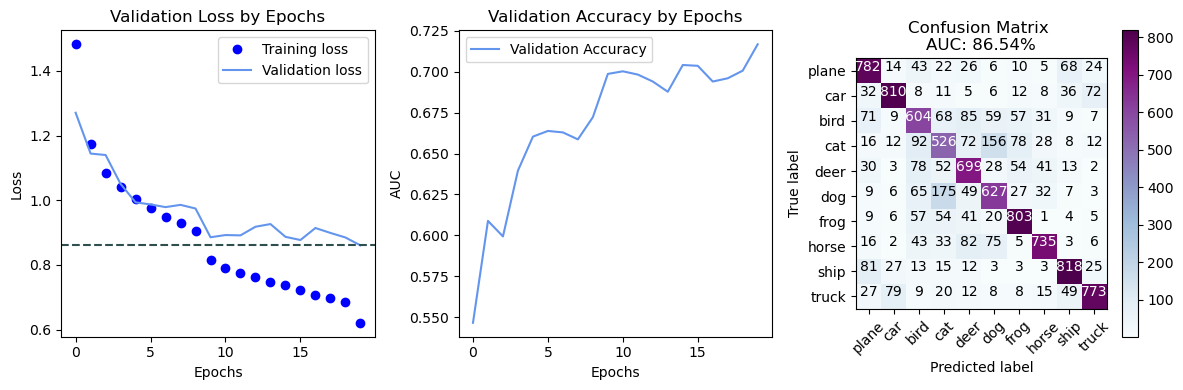

In [26]:
plot_training_metrics(cnn_history, model_CNN, test_data, y_true, y_pred, classes)

In [27]:
y_true_v, y_pred_v, y_pred_prob_v = predict(model_ViT, test_dl, device)


 Model AUC 85.85%, Accuracy 70.44% on Test Data

              precision    recall  f1-score   support

       plane       0.76      0.70      0.73      1000
         car       0.80      0.84      0.82      1000
        bird       0.64      0.53      0.58      1000
         cat       0.56      0.52      0.54      1000
        deer       0.66      0.66      0.66      1000
         dog       0.61      0.61      0.61      1000
        frog       0.71      0.82      0.76      1000
       horse       0.72      0.77      0.75      1000
        ship       0.77      0.83      0.80      1000
       truck       0.78      0.78      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



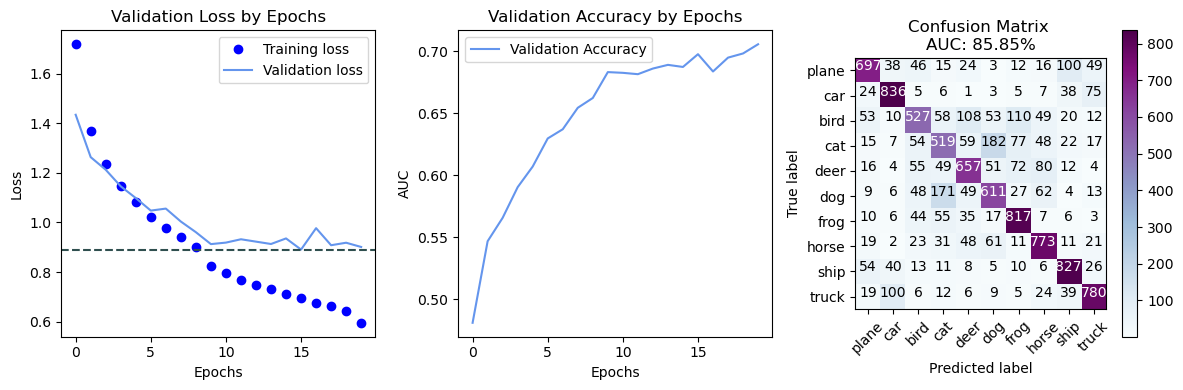

In [28]:
plot_training_metrics(vit_history, model_ViT, test_data, y_true_v, y_pred_v, classes)

In [29]:
y_true, y_pred, y_pred_prob = predict(model_CNN2, test_dl, device)


 Model AUC 85.85%, Accuracy 70.44% on Test Data

              precision    recall  f1-score   support

       plane       0.76      0.70      0.73      1000
         car       0.80      0.84      0.82      1000
        bird       0.64      0.53      0.58      1000
         cat       0.56      0.52      0.54      1000
        deer       0.66      0.66      0.66      1000
         dog       0.61      0.61      0.61      1000
        frog       0.71      0.82      0.76      1000
       horse       0.72      0.77      0.75      1000
        ship       0.77      0.83      0.80      1000
       truck       0.78      0.78      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



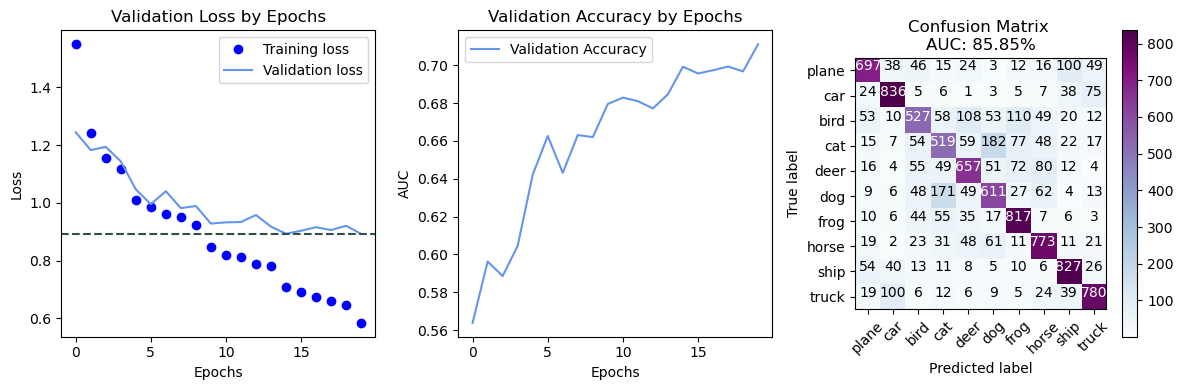

In [30]:
plot_training_metrics(cnn2_history, model_CNN2, test_data, y_true_v, y_pred_v, classes)

In [31]:
y_true, y_pred, y_pred_prob = predict(model_ViT2, test_dl, device)


 Model AUC 85.85%, Accuracy 70.44% on Test Data

              precision    recall  f1-score   support

       plane       0.76      0.70      0.73      1000
         car       0.80      0.84      0.82      1000
        bird       0.64      0.53      0.58      1000
         cat       0.56      0.52      0.54      1000
        deer       0.66      0.66      0.66      1000
         dog       0.61      0.61      0.61      1000
        frog       0.71      0.82      0.76      1000
       horse       0.72      0.77      0.75      1000
        ship       0.77      0.83      0.80      1000
       truck       0.78      0.78      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



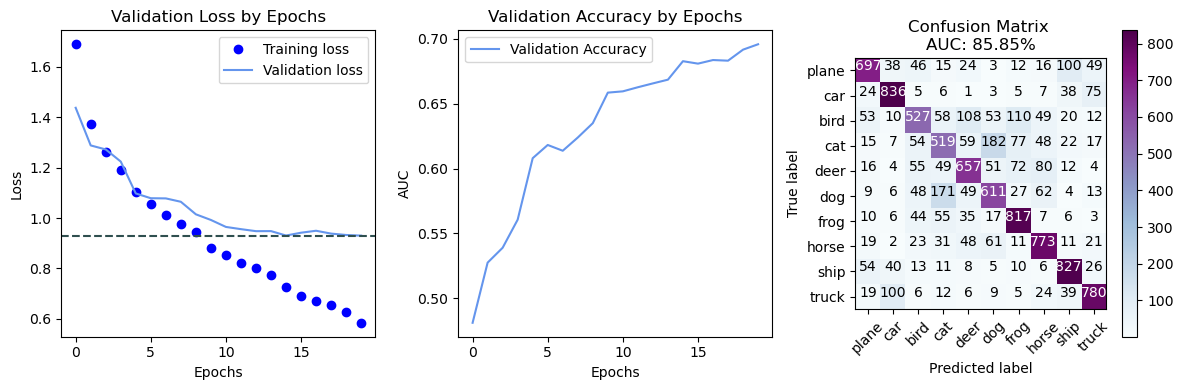

In [32]:
plot_training_metrics(vit2_history, model_ViT2, test_data, y_true_v, y_pred_v, classes)